# Notebook 3: Tool Integration

## Learning Objectives
- Understand how to create and bind tools to LLMs
- Use the `ToolNode` for automatic tool execution
- Build an agent loop that uses tools iteratively

## Why Tools?

LLMs are powerful but limited to their training data. Tools extend their capabilities:
- **Search**: Access real-time information
- **Calculate**: Precise mathematical operations
- **APIs**: Interact with external services
- **Databases**: Query and update data

LangGraph provides elegant patterns for tool use with proper control flow.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from IPython.display import Image, display

llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

## Creating Tools

Tools are functions decorated with `@tool`. The docstring becomes the tool description that the LLM uses to decide when to call it.

In [2]:
@tool
def calculator(expression: str) -> str:
    """Calculate a mathematical expression. Use this for any math operations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', 'sqrt(16)', '10 * 5')
    """
    try:
        # Using eval with limited scope for safety
        import math
        allowed_names = {k: v for k, v in math.__dict__.items() if not k.startswith('_')}
        allowed_names['abs'] = abs
        result = eval(expression, {"__builtins__": {}}, allowed_names)
        return str(result)
    except Exception as e:
        return f"Error: {str(e)}"

@tool
def get_weather(city: str) -> str:
    """Get the current weather for a city.
    
    Args:
        city: The name of the city to get weather for
    """
    # Simulated weather data
    weather_data = {
        "new york": "Sunny, 72°F (22°C)",
        "london": "Cloudy, 59°F (15°C)",
        "tokyo": "Rainy, 68°F (20°C)",
        "sydney": "Clear, 77°F (25°C)",
    }
    return weather_data.get(city.lower(), f"Weather data not available for {city}")

@tool
def search_knowledge_base(query: str) -> str:
    """Search the internal knowledge base for information.
    
    Args:
        query: The search query
    """
    # Simulated knowledge base
    kb = {
        "refund policy": "Refunds are available within 30 days of purchase with receipt.",
        "business hours": "We're open Monday-Friday 9am-5pm EST.",
        "contact": "Email: support@example.com, Phone: 1-800-EXAMPLE",
    }
    
    for key, value in kb.items():
        if key in query.lower():
            return value
    return "No relevant information found in knowledge base."

# List of tools
tools = [calculator, get_weather, search_knowledge_base]

print("Tools created:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools created:
  - calculator: Calculate a mathematical expression. Use this for ...
  - get_weather: Get the current weather for a city.

Args:
    cit...
  - search_knowledge_base: Search the internal knowledge base for information...


## Binding Tools to the LLM

We need to tell the LLM about the available tools so it can decide when to use them.

In [3]:
# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

# Test it
response = llm_with_tools.invoke("What's 25 * 17?")
print("Response type:", type(response))
print("Tool calls:", response.tool_calls)

Response type: <class 'langchain_core.messages.ai.AIMessage'>
Tool calls: []


## The Agent Loop Pattern

The standard pattern for tool-using agents:

1. **Agent Node**: LLM decides to use a tool OR respond
2. **Tool Node**: Executes the tool and returns result
3. **Loop**: Go back to Agent with tool result
4. **End**: When LLM responds without tools

```
START → Agent → (has tool calls?) → Tools → Agent → ... → END
              ↘ (no tool calls) → END
```

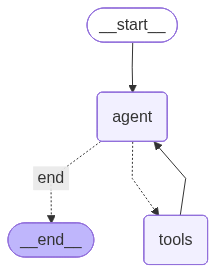

In [4]:
# Define the state
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

# The agent node - calls the LLM
def agent(state: AgentState) -> dict:
    """Call the LLM with tools"""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create a ToolNode - it automatically executes tool calls
tool_node = ToolNode(tools)

# Router function - check if there are tool calls
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Decide whether to use tools or end"""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools
    if last_message.tool_calls:
        return "tools"
    # Otherwise, end
    return "end"

# Build the graph
builder = StateGraph(AgentState)

builder.add_node("agent", agent)
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")

# Conditional edge from agent
builder.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

# Tools always go back to agent
builder.add_edge("tools", "agent")

agent_graph = builder.compile()

display(Image(agent_graph.get_graph().draw_mermaid_png()))

In [9]:
# Test the agent with different queries
test_queries = [
    "What's 156 * 23 + 89?",
    "What's the weather in Tokyo?",
    "What's your refund policy?",
    "Hello, how are you?"  # No tool needed
]

for query in test_queries:
    print(f"Query: {query}")
    result = agent_graph.invoke({"messages": [HumanMessage(content=query)]})
    print(f"Response: {result['messages'][-1].content}")
    print("-" * 50)

Query: What's 156 * 23 + 89?
Response: 3677

Calculation: 156 × 23 = 3588, then 3588 + 89 = 3677.
--------------------------------------------------
Query: What's the weather in Tokyo?
Response: Right now in Tokyo: rainy, 68°F (20°C). Want the forecast for today or the next few days?
--------------------------------------------------
Query: What's your refund policy?
Response: I don’t have a universal refund policy for this chat—refunds are handled by the product or platform you’re using, and policies vary by provider.

If you share which product or service you purchased (e.g., this platform’s API, ChatGPT Plus, a specific app, etc.), I can point you to the exact policy. In the meantime, here are general steps you can take:

- Check the provider’s Terms of Service or Refund Policy on their website or in the app’s Billing/Orders section.
- Find the purchase in your Billing/Orders history and look for a “Request refund” or support option.
- If required, contact support with: order number

## Streaming Tool Execution

For better UX, you can stream the graph execution to see each step as it happens.

In [10]:
# Stream the execution to see each step
query = "What's the weather in London, and what's 100 divided by the temperature in Fahrenheit?"

print(f"Query: {query}\n")

for event in agent_graph.stream({"messages": [HumanMessage(content=query)]}):
    for node_name, output in event.items():
        print(f"--- {node_name.upper()} ---")
        last_msg = output["messages"][-1]
        if hasattr(last_msg, 'tool_calls') and last_msg.tool_calls:
            for tc in last_msg.tool_calls:
                print(f"Tool call: {tc['name']}({tc['args']})")
        else:
            print(f"Content: {last_msg.content[:200] if last_msg.content else '(no content)'}")
        print()

Query: What's the weather in London, and what's 100 divided by the temperature in Fahrenheit?

--- AGENT ---
Tool call: get_weather({'city': 'London'})

--- TOOLS ---
Content: Cloudy, 59°F (15°C)

--- AGENT ---
Content: - London weather: Cloudy, 59°F (15°C).
- 100 divided by the temperature in Fahrenheit: 100 ÷ 59 ≈ 1.695.



## Using Tavily for Web Search

For real web search capabilities, you can use Tavily (requires API key in `.env`).

In [2]:
# Only run this cell if you have a TAVILY_API_KEY
try:
    from langchain_tavily import TavilySearch
    
    search_tool = TavilySearch(max_results=2)
    
    # Test the search
    result = search_tool.invoke("LangGraph latest features 2024")
    print("Search works! Results:")
    print(result[:500] if len(result) > 500 else result)
except Exception as e:
    print(f"Tavily not available: {e}")
    print("Skipping web search examples...")

Search works! Results:
{'query': 'LangGraph latest features 2024', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://changelog.langchain.com/?categories=cat_5UBL6DD8PcXXL&date=2024-10-01', 'title': 'October 2024 - LangChain - Changelog', 'content': 'LangGraph is now compatible with Python 3.13 · LangGraph long-term memory support · LangGraph Templates: Build configurable agentic workflows · Performance', 'score': 0.8458536, 'raw_content': None}, {'url': 'https://changelog.langchain.com/?categories=cat_5UBL6DD8PcXXL&date=2025-01-01&page=2', 'title': 'LangChain - Changelog', 'content': 'LangGraph Python: Dynamic breakpoints, error tracking in checkpointer, and custom configs · August 30, 2024 ; Reliable streaming and efficient state', 'score': 0.79041743, 'raw_content': None}], 'response_time': 1.04, 'request_id': 'adecf656-78bb-41cf-9ab1-e1f7a22681dd'}


---

## Exercise 3: Build a Research Assistant

Create an agent with the following tools:
1. `search_arxiv(query)` - Simulated paper search
2. `summarize_paper(paper_id)` - Simulated paper summary
3. `save_notes(content)` - Save research notes

The agent should be able to:
- Search for papers on a topic
- Get summaries of specific papers
- Save notes about findings

In [ ]:
# YOUR CODE HERE

# Simulated database
PAPERS_DB = {
    "arxiv:2301.001": {"title": "Advances in LLM Agents", "authors": "Smith et al.", "year": 2023},
    "arxiv:2301.002": {"title": "Multi-Agent Collaboration", "authors": "Johnson et al.", "year": 2023},
    "arxiv:2302.001": {"title": "Tool Use in Language Models", "authors": "Williams et al.", "year": 2023},
}

research_notes = []

@tool
def search_arxiv(query: str) -> str:
    """Search for academic papers on arXiv.
    
    Args:
        query: The search query for finding papers
    """
    # TODO: Return matching papers from PAPERS_DB
    pass

@tool 
def summarize_paper(paper_id: str) -> str:
    """Get a summary of a specific paper.
    
    Args:
        paper_id: The paper ID (e.g., 'arxiv:2301.001')
    """
    # TODO: Return paper details or "not found"
    pass

@tool
def save_notes(content: str) -> str:
    """Save research notes for later reference.
    
    Args:
        content: The notes to save
    """
    # TODO: Append to research_notes and confirm
    pass

# TODO: Build the agent graph

# Test:
# result = research_agent.invoke({"messages": [HumanMessage(content="Find papers about agents and summarize them")]})

### Exercise 3: Solution (hidden)

<details>
<summary>Click to reveal solution</summary>

```python
PAPERS_DB = {
    "arxiv:2301.001": {"title": "Advances in LLM Agents", "authors": "Smith et al.", "year": 2023},
    "arxiv:2301.002": {"title": "Multi-Agent Collaboration", "authors": "Johnson et al.", "year": 2023},
    "arxiv:2302.001": {"title": "Tool Use in Language Models", "authors": "Williams et al.", "year": 2023},
}

research_notes = []

@tool
def search_arxiv(query: str) -> str:
    """Search for academic papers."""
    results = []
    for paper_id, info in PAPERS_DB.items():
        if any(word.lower() in info["title"].lower() for word in query.split()):
            results.append(f"{paper_id}: {info['title']} ({info['authors']}, {info['year']})")
    return "\n".join(results) if results else "No papers found."

@tool
def summarize_paper(paper_id: str) -> str:
    """Get paper summary."""
    if paper_id in PAPERS_DB:
        info = PAPERS_DB[paper_id]
        return f"Title: {info['title']}\nAuthors: {info['authors']}\nYear: {info['year']}\nSummary: This paper explores advances in the field."
    return "Paper not found."

@tool
def save_notes(content: str) -> str:
    """Save notes."""
    research_notes.append(content)
    return f"Notes saved! Total notes: {len(research_notes)}"

research_tools = [search_arxiv, summarize_paper, save_notes]
research_llm = llm.bind_tools(research_tools)

def research_agent(state: AgentState) -> dict:
    messages = [
        SystemMessage(content="You are a research assistant. Use tools to find papers, summarize them, and save notes."),
        *state["messages"]
    ]
    return {"messages": [research_llm.invoke(messages)]}

builder = StateGraph(AgentState)
builder.add_node("agent", research_agent)
builder.add_node("tools", ToolNode(research_tools))
builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, {"tools": "tools", "end": END})
builder.add_edge("tools", "agent")

research_graph = builder.compile()
```
</details>

## Key Takeaways

1. **Tools** are decorated functions with clear docstrings
2. **bind_tools()** tells the LLM what tools are available
3. **ToolNode** automatically executes tool calls
4. The **agent loop** pattern: Agent → Tools → Agent → ... → END

## Next: Persistence & Memory

In the next notebook, we'll learn how to add memory to our agents for multi-turn conversations!